In [1]:
# code for loading the format for the notebook
import os

# path : store the current path to convert back to it later
path = os.getcwd()
os.chdir('../notebook_format')
from formats import load_style
load_style()

In [2]:
os.chdir(path)
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.linear_model import RidgeCV
from sklearn.linear_model import LassoCV
from sklearn.datasets import load_boston
from sklearn.preprocessing import StandardScaler
from sklearn.cross_validation import train_test_split

# Regularization

Before discussing about regularization, we'll do a quick recap on the notion of **overfitting** and the **bias-variance tradeoff**. 

**Overfitting:** So what is overfitting? Well, to put it in simplier terms it's when we built a model that is too complex that it matches the training data "too closely" or we can say that the model has started to learn not only the signal, but also the noise in the data. The result of this is that our model will do well on the training data, but won't generalize to out-of-sample data, data that we have not seen before. 

**Bias-Variance tradeoff:** When we discuss prediction models, prediction errors can be decomposed into two main subcomponents we care about: error due to "bias" and error due to "variance". Understanding these two types of error can help us diagnose model results and avoid the mistake of over/under fitting. A typical graph of discussing this is shown below:

![Bias-variance tradeoff](images/bias_variance.png)

- **Bias**, the red line, measures how far off in general our models' predictions are from the correct value. Thus as our model gets more and more complex we will become more and more accurate about our predictions (Error steadily decreases).
- **Variance**, the cyan line (is it cyan ..?), measures how different can our model be from one to another, as we're looking at different possible data sets? If the estimated model will vary dramatically from one data set to the other, then we will have very erratic predictions, because our prediction will be extremely sensitive to what data set we obtain. As the complexity of our model rises and variance becomes our primary concern.

When creating a model, our goal is to locate the optimum model complexity. If our model complexity exceeds this sweet spot, we are in effect overfitting our model; while if our complexity falls short of the sweet spot, we are underfitting the model. With all of that in mind, the notion of **regularization** is simply a useful technique to use when we think our model is too complex (models that have low bias, but high variance). It is a method for "constraining" or "regularizing" the **size of the coefficients** ("shrinking" them towards zero). The specific regularization techniques we'll be discussing are **Ridge Regression** and **Lasso Regression**.

## Ridge and Lasso Regression

Recall that for a normal linear regression model of:

$$Y = \beta_0 + \beta_1X_1 + ... + \beta_pX_p$$

We would estimate its coefficients using the least squares criterion, which minimizes the residual sum of squares (RSS). Or graphically, we're fitting the blue line to our data (the black points) that minimizes the sum of the distances between the points and the blue line (sum of the red lines) as shown below.

![Estimating coefficients](images/estimating_coefficients.png)

Mathematically, this can be denoted as:

$$RSS = \sum_{i=1}^n \left( y_i - ( \beta_0 + \sum_{j=1}^p \beta_jx_{ij} ) \right)^2$$

Where:

- $n$ is the **total number of observations (data)**.
- $y_i$ is the **actual output value of the observation (data)**.
- $p$ is the **total number of features**.
- $\beta_j$ is a **model's coefficient**.
- $x_{ij}$ is the **$i_{th}$ observation, $j_{th}$ feature's value**.
- $\beta_0 + \sum_{j=1}^p \beta_jx_{ij}$ is the **predicted output of each observation**.

Regularized linear regression models are very similar to least squares, except that the coefficients are estimated by minimizing a slightly objective function. we **minimize the sum of RSS and a "penalty term"** that penalizes coefficient size.

**Ridge regression** (or "L2 regularization") minimizes: $$\text{RSS} + \alpha \sum_{j=1}^p \beta_j^2$$

**Lasso regression** (or "L1 regularization") minimizes: $$\text{RSS} + \alpha \sum_{j=1}^p \lvert \beta_j \rvert$$

Where $\alpha$ is a **tuning parameter** that seeks to balance between the fit of the model to the data and the magnitude of the model's coefficients:

- A tiny $\alpha$ imposes no penalty on the coefficient size, and is equivalent to a normal linear regression.
- Increasing $\alpha$ penalizes the coefficients and thus shrinks them towards zero.

Thus you can think of it as, we're balancing two things to measure the model's total quality. The RSS, measures how well the model is going to fit the data, and then the magnitude of the coefficients, which can be problematic if they become too big.

Let's look at some examples. In the following section, we'll load the [Boston Housing Dataset](http://facweb.cs.depaul.edu/mobasher/classes/CSC478/Data/housing-dscr.txt), which contains some dataset about the housing values in suburbs of Boston. We'll choose the first few features, train a ridge and lasso regression separately at look at the estimated coefficients' weight for different $\alpha$ parameter. 

Note that we're choosing the first few features because we'll later use a plot to show the affect of the $\alpha$ parameter on the estimated coefficients' weight and too many features will make the plot pretty unappealing. The model's interpreability or performance is not the main focus here.

In [3]:
boston = load_boston()

feature_num = 7
X = boston.data[ :, :feature_num ] # input data, meaning of each variable is in the link above
y = boston.target # housing prices
features = boston.feature_names[:feature_num]

pd.DataFrame( X, columns = features ).head()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE
0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2
1,0.02731,0.0,7.07,0.0,0.469,6.421,78.9
2,0.02729,0.0,7.07,0.0,0.469,7.185,61.1
3,0.03237,0.0,2.18,0.0,0.458,6.998,45.8
4,0.06905,0.0,2.18,0.0,0.458,7.147,54.2


In [4]:
# split into training and testing sets and standardize them
X_train, X_test, y_train, y_test = train_test_split( X, y, random_state = 1 )
std = StandardScaler()
X_train_std = std.fit_transform(X_train)
X_test_std  = std.transform(X_test)

In [5]:
# loop through different penalty score (alpha) and obtain the estimated coefficient (weights)
alphas = 10 ** np.arange( 1, 6 )
print( 'different alpha values:', alphas )

# stores the weights of each feature
ridge_weight = []
for alpha in alphas:    
    ridge = Ridge( alpha = alpha, fit_intercept = True )
    ridge.fit( X_train_std, y_train )
    ridge_weight.append(ridge.coef_)

different alpha values: [    10    100   1000  10000 100000]


In [6]:
def weight_versus_alpha_plot( weight, alphas, features ):
    """
    Pass in the estimated weight, the alpha value and the names
    for the features and plot the model's estimated coefficient weight 
    for different alpha values
    """
    
    fig = plt.figure( figsize = ( 8, 6 ) )
    
    # ensure that the weight is an array
    weight = np.array(weight)
    for col in range(weight.shape[1]):
        plt.plot( alphas, weight[ :, col ], label = features[col] )

    plt.axhline( 0, color = "black", linestyle = "--", linewidth = 3 )
    plt.legend( bbox_to_anchor = ( 1.3, 0.9 ) ) # manually specify the coordinate of the legend
    plt.title("Coefficient's Weight as Alpha Grows")
    plt.ylabel("coefficient's weight")
    plt.xlabel("alpha")
    return fig

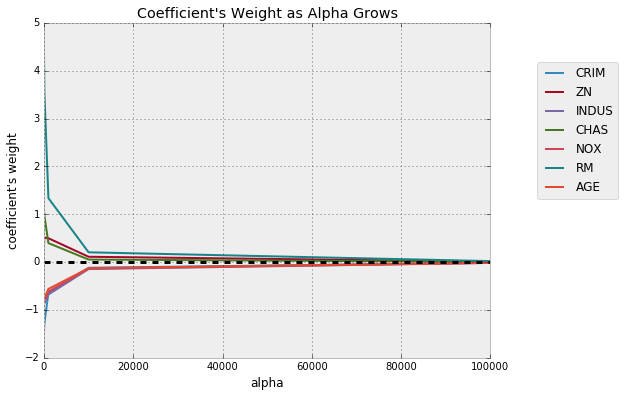

In [7]:
ridge_fig = weight_versus_alpha_plot( ridge_weight, alphas, features )

different alpha values: [0.001, 0.01, 0.1, 1, 5]


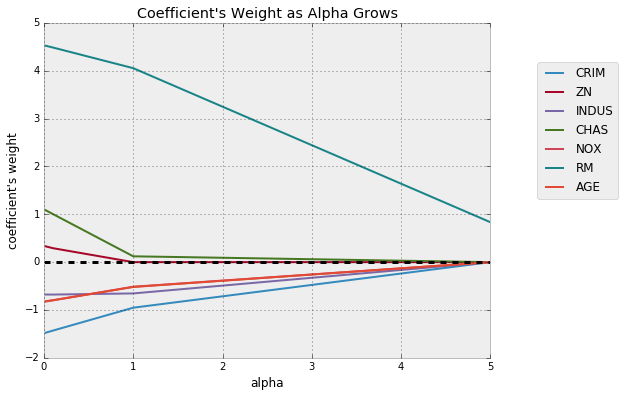

In [8]:
# does the same thing above except for lasso
alphas = [ 0.001, 0.01, 0.1, 1, 5 ]
print( 'different alpha values:', alphas )

lasso_weight = []
for alpha in alphas:    
    lasso = Lasso( alpha = alpha, fit_intercept = True )
    lasso.fit( X_train_std, y_train )
    lasso_weight.append(lasso.coef_)

lasso_fig = weight_versus_alpha_plot( lasso_weight, alphas, features )

## Visualizing Regularization

From the result above, we can see that as the penalty value, $\alpha$ increases:

- **Lasso regression** shrinks coefficients all the way to zero, thus removing them from the model.
- **Ridge regression** shrinks coefficients toward zero, but they rarely reach zero.

To get a sense of why this is happening, the visualization below depicts what happens when you apply the two different regularization. The general idea is that you are restricting the allowed values of your coefficients to a certain "region". Within that region, you want to find the coefficients that result in the best model.

![Lasso and Ridge Coefficient Plots](images/lasso_ridge_coefficients.png)

In this diagram, we are fitting a linear regression model with two features, $x_1$ and $x_2$.

- $\hat\beta$ represents the set of two coefficients, $\beta_1$ and $\beta_2$, which minimize the RSS for the **unregularized model**.
- The ellipses that are centered around $\hat\beta$ represent **regions of constant RSS**. In other words, all of the points on a given ellipse share a common value of the RSS, despite the fact that they may have different values for $\beta_1$ and $\beta_2$. As the ellipses expand away from the least squares coefficient estimates, the RSS increases.
- Regularization restricts the allowed positions of $\hat\beta$ to the **blue constraint region**. In this case, $\hat\beta$ is **not** within the blue constraint region. Thus, we need to move $\hat\beta$ until it intersects the blue region, while increasing the RSS as little as possible.
    - For **ridge**, this region is a **circle** because it constrains the square of the coefficients. Thus the intersection will not generally occur on an axis, and so the coefficient estimates will be typically be non-zero.
    - For **lasso**, this region is a **diamond** because it constrains the absolute value of the coefficients. Because the constraint has corners at each of the axes, and so the ellipse will often intersect the constraint region at an axis. When this occurs, one of the coefficients will equal zero. In higher dimensions, many of the coefficient estimates may equal zero simultaneously. In the figure above, the intersection occurs at $\beta_1 = 0$, and so the resulting model will only include $\beta_2$.
- The **size of the blue constraint region** is determined by $\alpha$, with a smaller $\alpha$ resulting in a larger region:
    - When $\alpha$ is zero, the blue region is infinitely large, and thus the coefficient sizes are not constrained.
    - When $\alpha$ increases, the blue region gets smaller and smaller. 

## Advice For Applying Regularization

**Signs and causes of overfitting in the original regression model**

- Linear models can overfit if you include irrelevant features, meaning features that are unrelated to the response. Or if you include highly correlated features, meaing two or more predictor variables are closely related to one another. Because it will learn a coefficient for every feature you include in the model, regardless of whether that feature has the signal or the noise. This is especially a problem when p (number of features) is close to n (number of observations).
- Linear models that have large estimated coefficients is a sign that the model may be overfitting the data. The larger the absolute value of the coefficient, the more power it has to change the predicted response, resulting in a higher variance.

**Should features be standardized?** Yes, because L1 and L2 regularizers of linear models assume that all features are centered around 0 and have variance in the same order. If a feature has a variance that is orders of magnitude larger that others, features would be penalized simply because of their scale and make the model unable to learn from other features correctly as expected. Also, standardizing avoids penalizing the intercept, which wouldn't make intuitive sense.

**How should you choose between Lasso regression and Ridge regression?**

- Lasso regression is preferred if we want a sparse model, meaning that we believe many features are irrelevant to the output. This also increases model's interprebality.
- If model performance is your primary concern, it is best to try both and see which one works better.
- You should also note that that there's also a ElasticNet regression, that is a combination of lasso regression and ridge Regression.

**How do we choose the $\alpha$ parameter?**  So, you either use a validation set, if you have lots of data or use cross validation for smaller data sets. See a quick examples below that uses cross validation with `RidgeCV` and `LassoCV`, which is function that performs ridge regression and lasso regression with built-in cross-validation of the alpha parameter.

In [9]:
# alpha: array of alpha values to try; must be positive, increase for more regularization
# create an array of alpha values and select the best one with RidgeCV
alpha_range = 10. ** np.arange( -2, 3 )
ridge_cv = RidgeCV( alphas = alpha_range, fit_intercept = True )
ridge_cv.fit( X_train_std, y_train )

# examine the coefficients and the errors of the predictions 
# using the best alpha value
y_pred = ridge_cv.predict(X_test_std)
print( 'coefficients:\n', ridge_cv.coef_ )
print( 'best alpha:\n'  , ridge_cv.alpha_ )
print( '\nRSS:', np.sum( ( y_test - y_pred ) ** 2 ) )

coefficients:
 [-1.46163308  0.36740178 -0.71329997  1.09068406 -0.82505212  4.40548383
 -0.8073266 ]
best alpha:
 10.0

RSS: 4370.70361669


In [10]:
# n_alphas: number of alpha values (automatically chosen) to try
# select the best alpha with LassoCV
lasso_cv = LassoCV( n_alphas = 10, fit_intercept = True )
lasso_cv.fit( X_train_std, y_train )

# examine the coefficients and the errors of the predictions 
# using the best alpha value
y_pred = lasso_cv.predict(X_test_std)
print( 'coefficients:\n', lasso_cv.coef_ )
print( 'best alpha:\n'  , lasso_cv.alpha_ )
print( '\nRSS:', np.sum( ( y_test - y_pred ) ** 2 ) )

coefficients:
 [-1.47111127  0.32647134 -0.67724752  1.07728944 -0.8207456   4.52111316
 -0.81477595]
best alpha:
 0.0270845198472

RSS: 4313.02171284


## Reference

- [Understanding the Bias-Variance Tradeoff](http://scott.fortmann-roe.com/docs/BiasVariance.html)
- [General Assembly's Data Science Course's Notebook on Regularization](http://nbviewer.jupyter.org/github/justmarkham/DAT8/blob/master/notebooks/20_regularization.ipynb)